## QAOA
Given a classical cost function $C(z)$ defined on n-bit strings $z = (z_1, z_2, . . . , z_n) \in \{+1, −1\}^{n}$, the QAOA is a quantum algorithm that aims to find a string $z$ such that $C(z)$ is close to its absolute minimum. The cost function $C$ can be written as an operator that is diagonal in the computational basis, defined as

$$
C|z\rangle = C(z)|z\rangle
$$

The QAOA consists of two components that are repeatedly applied. The first component is parameterized evolution under the diagonal problem
Hamiltonian C,
$$
U_{C}(\gamma) = e^{-i\gamma C}
$$

The second component is parameterized evolution under a local transverse field driver Hamiltonian B,

$$
U_{B}(\beta) = e^{−i\beta B} = \prod_{j=1}^{n}e^{-i\beta X_{j}} \;;\;   B = \sum_{j=1}^{n}X_{j}
$$

The QAOA is a variational algorithm that uses repeated application of these unitaries to prepare a parameterized
state that is then optimized. The depth of the variational algorithm is usually denoted as “p” in the QAOA literature.
Specifically, for depth p we prepare a state parameterized by $\gamma = (\gamma_1, . . . , \gamma_p)$ and $\beta = (\beta_1, . . . , \beta_p)$

$$
|\gamma, \beta\rangle = U_{B}(\beta_p) U_{C}(\gamma_p) ... U_{B}(\beta_1) U_{C}(\gamma_1) |+\rangle^{\otimes n}
$$

For a given p, we attempt to find parameters that minimize the expectation value of the cost
$$
\langle C \rangle = \langle \gamma, \beta | C | \gamma, \beta \rangle
$$

## SK Model

The Sherrington-Kirkpatrick (SK) model describes a classical spin system with all-to-all couplings between the $n$ spins. The classical cost function $C$ is defined as:
$$
C(z) = \sum_{j < k}^{n} w_{j, k} z_{j} z_{k} \; \text{where}\;  w_{j, k} \in \{+1, -1\}
$$

Since the $Z_{j}Z_{k}$ operators all commute with each other, we can write $U_{C}(\gamma)$ as follows:

$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$

Thus, we can decompose $U_{C}(\gamma)$ into $\frac{n(n-1)}{2}$ 2-qubit operations. Each of the 2-qubit unitaries can be implemented in Cirq as an `ZZPowGate` gate as follows:

```python
    def rzz(gamma):
        return cirq.ZZPowGate(exponent=2 * gamma / np.pi, global_shift=-0.5)
```

A sample QAOA circuit for the SK model is constructed using Cirq in the following cell

In [10]:
import cirq
import attrs
import sympy
import numpy as np
from typing import Sequence, Union, Tuple

def rzz(gamma):
    return cirq.ZZPowGate(exponent=2 * gamma / np.pi, global_shift=-0.5)

@attrs.frozen
class PhaseOracle(cirq.Gate):
    gamma: Union[float, sympy.Symbol]
    bitsize: int
    weights: Tuple[int, ...]

    def _num_qubits_(self) -> int:
        return self.bitsize

    def _decompose_(self, qubits):
        w_idx = 0
        for i in range(n):
            for j in range(i+1, n):
                yield rzz(w[w_idx] * gamma).on(qubits[i], qubits[j])
                w_idx = w_idx + 1
    
    def __str__(self):
        return f'PhaseOracle[{self.gamma}]'


def beta_layer(beta, q: Sequence[cirq.Qid]):
    yield cirq.Moment(cirq.Rx(rads = 2 * beta).on_each(*q))

def construct_cirq_circuit(n, w, gammas, betas):
    q = cirq.LineQubit.range(n)
    return cirq.Circuit(
        cirq.H.on_each(*q),
        [[
            PhaseOracle(gamma, n, w).on(*q), beta_layer(beta, q)
         ] for (gamma, beta) in zip(gammas, betas)
        ]
    )

n = 5
rng = np.random.default_rng(12345)
w = (-1) ** rng.integers(low=0, high=1, size=(n * (n - 1)) // 2, endpoint=True) # nC2 weights for the cost function.
p = 3
gamma = sympy.symbols(','.join(f'gamma_{i}' for i in range(p)))
beta = sympy.symbols(','.join(f'beta_{i}' for i in range(p)))
construct_cirq_circuit(n, w, gamma, beta)

0: ───H───PhaseOracle[gamma_0]───Rx(2*beta_0)───PhaseOracle[gamma_1]───Rx(2*beta_1)───PhaseOracle[gamma_2]───Rx(2*beta_2)───
          │                                     │                                     │
1: ───H───#2─────────────────────Rx(2*beta_0)───#2─────────────────────Rx(2*beta_1)───#2─────────────────────Rx(2*beta_2)───
          │                                     │                                     │
2: ───H───#3─────────────────────Rx(2*beta_0)───#3─────────────────────Rx(2*beta_1)───#3─────────────────────Rx(2*beta_2)───
          │                                     │                                     │
3: ───H───#4─────────────────────Rx(2*beta_0)───#4─────────────────────Rx(2*beta_1)───#4─────────────────────Rx(2*beta_2)───
          │                                     │                                     │
4: ───H───#5─────────────────────Rx(2*beta_0)───#5─────────────────────Rx(2*beta_1)───#5─────────────────────Rx(2*beta_2)───

## Optimized Phase Oracles for FT Resource Estimation
The phase oracle $O^{\text{phase}}(\gamma)$ is defined as 
$$
    O^{\text{phase}}(\gamma) |z\rangle = e^{-i \gamma C(z)} |z\rangle
$$

In the naive Cirq implementation shown above, the phase oracle $O^{\text{phase}}(\gamma)$ is implemented simply as the unitary $U_{C}(\gamma)$ defined as
$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$


However, in the Fault Tolerant setting, we aim to come up with optimized implementations of $O^{\text{phase}}(\gamma)$ that reduce the Toffoli count. One trick we can use is to compute the cost $C(z)$ for each bitstring $|z\rangle$ in a separate register and then apply a phasing operation to phase each state $|z\rangle |c(z)\rangle$ with a value proportional $\gamma * C(z)$. Phasing can be implemented by preparing an initial phase gradient state and then adding $\gamma * C(z)$ to the phase gradient register in order to apply a phase $e^{-i \gamma C(z)}$ to state $|z\rangle$

### Cost Function Evaluation Oracle
Let $O^{\text{direct}}$ represent an oracle that evaluates the cost function $C(z)$ and stores the output in a new clean register. 

$$
    O^{\text{direct}}|z\rangle |0\rangle^{\otimes\text{bdir}}  = |z\rangle |c(z)\rangle
$$

Here $b_{\text{dir}}$ is the bitsize of the newly allocated ancilla register and in the case of SK model, it is equal to $2\log{N}$. 

### Phase Evaluation via Addition
#### Rotaions via addition
Let $|\phi\rangle$ be a phase gradient state defined on a register of bitsize $b_{\text{grad}}$ as

$$
        |\phi_{\text{grad}}\rangle = \frac{1}{\sqrt{2^{b_{\text{grad}}}}} \sum_{k=0}^{2^{b_{\text{grad}}} - 1} \omega_{b_{\text{grad}}}^{-k} |k\rangle 
$$
where
$$
        \omega_{b_{\text{grad}}} = \exp\left(\frac{2\pi i}{2^{b_{\text{grad}}}}\right)
$$

Note that 

\begin{split}
  |\phi_{\text{grad}} + l\rangle = \omega_{b_{\text{grad}}}^{l} |\phi_{\text{grad}}\rangle \\
  |\phi_{\text{grad}} - l\rangle = \omega_{b_{\text{grad}}}^{-l} |\phi_{\text{grad}}\rangle \\
  \text{where}\; \omega_{b_{\text{grad}}}^{l} = \exp\left(\frac{i 2\pi l}{2^{b_{\text{grad}}}}\right)
\end{split}

Thus, by adding $l$ into the phase register, we've applied a phase to the state that's proportional to $l$.

Therefore, to apply a phase of $\exp\left(-i\gamma c(z)\right)$ to state $|z\rangle|c(z)\rangle$, we need

$$
U^{\text{phase}}(\gamma) = \sum_{k=0}^{2^{b_{\text{dir}}} - 1} \omega_{b_{\text{dir}}}^{-\widetilde{\gamma} k} |k\rangle\langle k|
$$
where
$$
\widetilde{\gamma} = \gamma \times \frac{2^{b_{\text{dir}}}}{2\pi}
$$
and we assume $\widetilde{\gamma} \le 1$
#### Determining $\gamma_{\text{bitsize}}$
Let the phase applied by the phasing oracle be $e^{-i\widetilde{\gamma C(z)}}$ s.t. $||\widetilde{\gamma C(z)} - \gamma C(z)|| \le \frac{1}{2^{b_{\text{pha}}}}$, then 

$$
\gamma_{\text{bitsize}} = \log{\widetilde{\gamma}} + b_{\text{pha}} + O(1)
$$

#### Determining $b_{\text{grad}}$
$$
b_{\text{grad}} = \left\lceil \log{\frac{(\gamma_{\text{bitsize}} + 2)\pi}{\epsilon}}\right\rceil
$$ 

represent the size of the phase gradient register. The cost to apply a phase $e^{-i \gamma c(z)}$ to a state $|z\rangle |c(z)\rangle$ given that we have a phase gradient state prepared on a register of size $b_{\text{grad}}$ is given by $(b_{\text{grad}} − 2)(\gamma_{\text{bitsize}} + 2)$ because multiplication of $c(z)$ with $\gamma$ and addition into phase gradient register can be reduced to $\gamma_{\text{bitsize}} + 2$ additions / subtractions of a power of 2 into the phase gradient register of size $\text{bgrad}$. Each addition into the phase gradient register takes $(\text{bgrad} − 2)$ Toffoli's


In [2]:
from qualtran import GateWithRegisters, Signature, Register, Side, SoquetT, BloqBuilder
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientState, AddScaledValIntoPhaseReg
from qualtran.bloqs.basic_gates import TGate, Hadamard, Rx
from qualtran.bloqs.on_each import OnEach
from typing import Dict, Optional, Set

@attrs.frozen
class SKModelCostEval(GateWithRegisters):
    n: int
    w: Tuple[int, ...]
    adjoint: bool = False
    
    @property
    def signature(self) -> Signature:
        side = Side.LEFT if self.adjoint else Side.RIGHT
        b_dir_bitsize = 2 * self.n
        return Signature([
            Register('x', self.n),
            Register('cost_reg', (2 * self.n).bit_length(), side=side)
        ])

    def bloq_counts(self, ssa: Optional['SympySymbolAllocator'] = None) -> Set[Tuple[int, 'Bloq']]:
        num_t = 0 if self.adjoint else self.n ** 2
        return {(self.n ** 2, TGate())}


@attrs.frozen
class QAOA_SKModel(GateWithRegisters):
    n: int
    w: Tuple[int, ...]
    gammas: Tuple[float, ...]
    betas: Tuple[float, ...]
    b_phase_bitsize: int = 20
    
    @property
    def signature(self) -> Signature:
        return Signature.build(x=self.n)


    @property
    def phase_epsilon(self) -> float:
        return 1 / 2 ** self.b_phase_bitsize
        
    @property
    def b_dir_bitsize(self) -> int:
        return (2 * self.n).bit_length()

    def gamma_prime(self, gamma: float) -> float:
        return gamma * (2 ** self.b_dir_bitsize) / (2 * np.pi)
    
    def gamma_bitsize(self, gamma: float) -> int:
        gamma_prime = self.gamma_prime(gamma)
        assert gamma_prime <= 1
        return int(-np.log2(gamma_prime)) + self.b_phase_bitsize

    @property
    def b_grad_bitsize(self) -> int:
        max_gamma_bitsize = max(self.gamma_bitsize(gamma) for gamma in self.gammas)
        return int(np.ceil(np.log2((max_gamma_bitsize + 2) * np.pi / self.phase_epsilon)))

    def build_composite_bloq(self, bb: 'BloqBuilder', x: 'Soquet') -> Dict[str, SoquetT]:
        # Apply Hadamard on initial qubits.
        x = bb.add(OnEach(self.n, Hadamard()), q = x)
        # Compute the gradient register that can be used for applying phase rotations.
        grad_reg = bb.add(PhaseGradientState(b_grad=self.b_grad_bitsize, eps=self.phase_epsilon))
        # Alternativey apply gamma layer and beta layer.
        for gamma, beta in zip(self.gammas, self.betas):
            # 1. Add gamma layer by adding a scaled val of `gamma` into phase_reg using cost_reg.
            # For each computational basis state, calculate it's cost in a new cost_reg.
            x, cost_reg = bb.add(SKModelCostEval(self.n, self.w), x=x)
            add_into_phase_reg = AddScaledValIntoPhaseReg(gamma_bitsize=self.gamma_bitsize(gamma), input_bitsize=self.b_dir_bitsize, phase_gradient_bitsize=self.b_grad_bitsize)
            cost_reg, grad_reg = bb.add(add_into_phase_reg, direct_reg=cost_reg, phase_reg=grad_reg)
            x = bb.add(SKModelCostEval(self.n, self.w, adjoint=True), x=x, cost_reg=cost_reg)
            # 2. Add beta layer
            x = bb.add(OnEach(self.n, Rx(angle=beta, eps=self.phase_epsilon)), q=x)
        # Uncompute the phase_reg.
        bb.add(PhaseGradientState(b_grad=self.b_grad_bitsize, eps=self.phase_epsilon, adjoint=True), b_grad=grad_reg)
        return {'x':x}

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


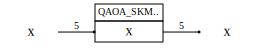

In [3]:
from qualtran.drawing import show_bloq

gammas = (0.01, 0.02, 0.03)
betas = (0.3, 0.2, 0.5)
qaoa_bloq = QAOA_SKModel(n, tuple(w), gammas, betas)
show_bloq(qaoa_bloq)

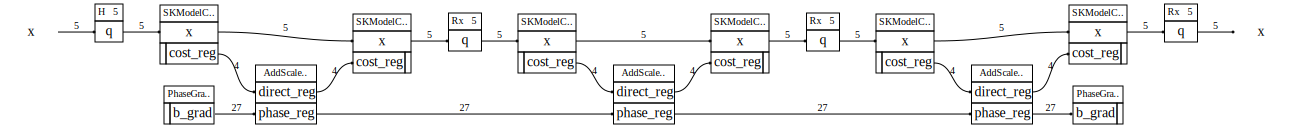

In [4]:
cbloq = qaoa_bloq.decompose_bloq()
show_bloq(cbloq)

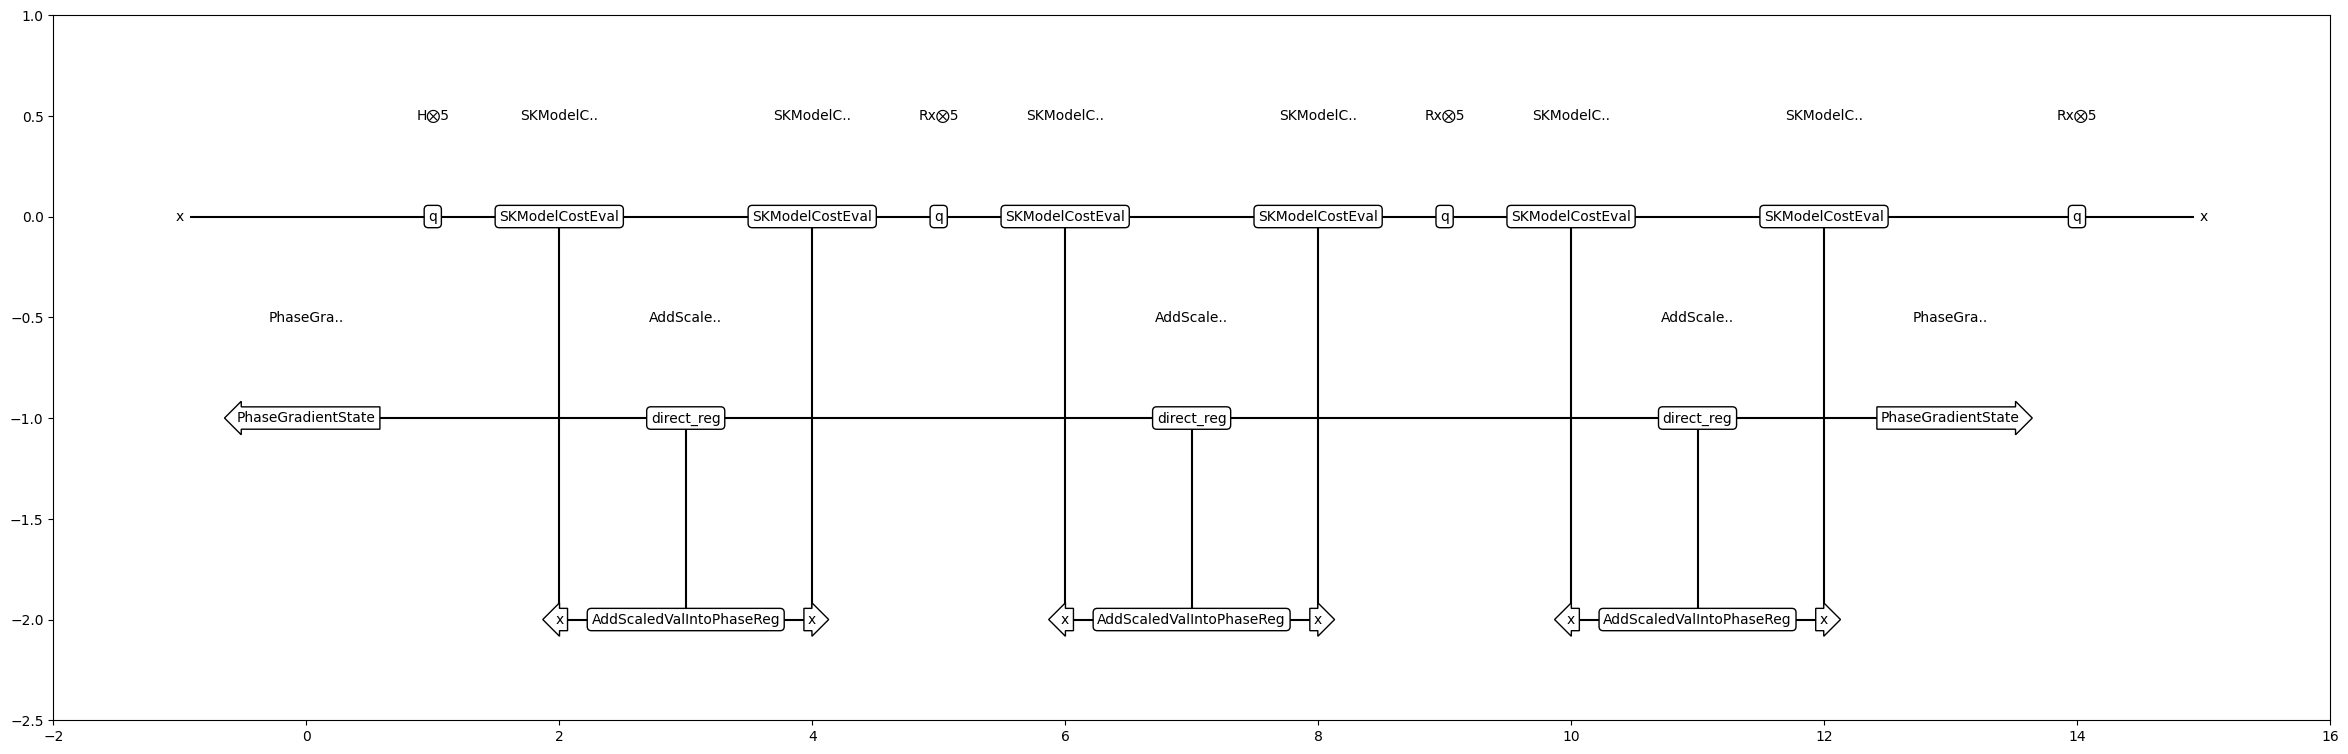

In [5]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
fig, ax = draw_musical_score(get_musical_score_data(cbloq))
fig.set_size_inches(25, 8)

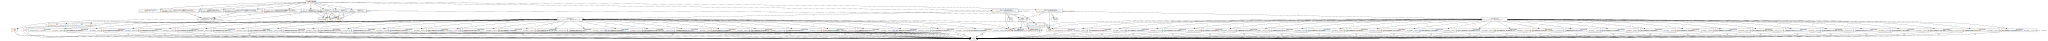

#### Counts totals:
 - `Allocate(n=1)`: 27
 - `CirqGateAsBloq(gate=(cirq.Y**0.5))`: 54
 - `CirqGateAsBloq(gate=cirq.XPowGate(global_shift=-0.25))`: 54
 - `Free(n=1)`: 27
 - `Hadamard()`: 5
 - `Join(n=27)`: 3
 - `Join(n=5)`: 4
 - `SKModelCostEval(n=5, w=(-1, 1, -1, 1, 1, -1, -1, -1, -1, 1), adjoint=False)`: 3
 - `SKModelCostEval(n=5, w=(-1, 1, -1, 1, 1, -1, -1, -1, -1, 1), adjoint=True)`: 3
 - `Split(n=27)`: 3
 - `Split(n=5)`: 4
 - `TGate()`: 6347

In [9]:
from qualtran.resource_counting import get_bloq_call_graph
from qualtran.drawing import show_call_graph, show_counts_sigma
g, sigma = get_bloq_call_graph(cbloq)
show_call_graph(g)
show_counts_sigma(sigma)